In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

from AtlasCommonUtils import SetAtlasStyle
from ROOT import TLatex



rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)




#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

Welcome to JupyROOT 6.22/02


In [2]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [3]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [4]:
def getJetData(inputFiles, isMC=False):
    
    cols = []
    scalar = []
    scalar.append('isBKG')
    scalar.append('polarization')
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    
    scalar.append('x_e')
    scalar.append('y_e')
    scalar.append('Q2_e')
    
    scalar.append('vertex_z')
    scalar.append('ptratio')
    scalar.append('ptmiss')
    scalar.append('acoplanarity')
    scalar.append('Empz')
    scalar.append('njets')

    scalar.append('e_eta')
    scalar.append('e_rap')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')
    scalar.append('e_phi')
    scalar.append('gene_pt')
    
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_dphi')
    cols.append('jet_z')
    cols.append('jet_eta')
    cols.append('jet_phi')
    
    if(isMC):
        scalar.append('Weight')
        scalar.append('WeightGen')
        scalar.append('geny')
        scalar.append('gene_rap')

        cols.append('genjet_p')
        cols.append('genjet_pt')
        cols.append('genjet_eta')

        cols.append('genjet_qt')
        cols.append('genjet_dphi')
        cols.append('genjet_z')
        

    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print ('\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds')
    return pd.concat([x for x in dataframes])

In [5]:
def applyCutsJets(df,isMC=False):
    temp = df
    temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    #temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    #temp = applyCut(temp, 'jet_pt>10', 'jet_pt>10')
    temp = applyCut(temp, 'isBKG<1.0', 'isBKG')

    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
        temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes

In [6]:
data_cut     = applyCutsJets(getJetData(['data_echeme.root']))
mc_cut = applyCutsJets(getJetData(['rapgap.root'],isMC=True),isMC=True)
altmc_cut= applyCutsJets(getJetData(['djangoh.root'],isMC=True),isMC=True)


 Processed data_echeme.root in 1.9 seconds
abs(vertex_z)<25 and and vertex_z!=0 111629  fraction kept: 90.0
0.2 < y < 0.7 66449  fraction kept: 59.5
Q2>150 66449  fraction kept: 100.0
isBKG 57257  fraction kept: 86.2

 Processed rapgap.root in 22.6 seconds
abs(vertex_z)<25 and and vertex_z!=0 958520  fraction kept: 96.7
0.2 < y < 0.7 677816  fraction kept: 70.7
Q2>150 677816  fraction kept: 100.0
isBKG 600050  fraction kept: 88.5

 Processed djangoh.root in 20.6 seconds
abs(vertex_z)<25 and and vertex_z!=0 920853  fraction kept: 96.6
0.2 < y < 0.7 650115  fraction kept: 70.6
Q2>150 650115  fraction kept: 100.0
isBKG 576934  fraction kept: 88.7


### Define UniFold Algorithm


In [7]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

2020-11-19 10:36:45.766250: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/miguel/anaconda3/envs/my_root_env/lib:
2020-11-19 10:36:45.766261: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Define features (input for the unfolding)

In [8]:
dphi_0_G = mc_cut['genjet_dphi']
dphi_0_S =mc_cut['jet_dphi']
dphi_unknown_G = altmc_cut['genjet_dphi']
dphi_unknown_S = altmc_cut['jet_dphi']

ept_0_G = mc_cut['gene_pt']
ept_0_S =mc_cut['e_pt']
ept_unknown_G = altmc_cut['gene_pt']
ept_unknown_S = altmc_cut['e_pt']

jetpt_0_G = mc_cut['genjet_pt']
jetpt_0_S =mc_cut['jet_pt']
jetpt_unknown_G = altmc_cut['genjet_pt']
jetpt_unknown_S = altmc_cut['jet_pt']

jeteta_0_G = mc_cut['genjet_eta']
jeteta_0_S =mc_cut['jet_eta']
jeteta_unknown_G = altmc_cut['genjet_eta']
jeteta_unknown_S = altmc_cut['jet_eta']

qt_0_G = mc_cut['genjet_qtnormjetpt']
qt_0_S = mc_cut['jet_qtnormjetpt']
qt_unknown_G = altmc_cut['genjet_qtnormjetpt']
qt_unknown_S = altmc_cut['jet_qtnormjetpt']

erap_0_G = mc_cut['gene_rap']
erap_0_S = mc_cut['e_rap']
erap_unknown_G = altmc_cut['gene_rap']
erap_unknown_S = altmc_cut['e_rap']

z_0_G = mc_cut['genjet_z']
z_0_S = mc_cut['jet_z']
z_unknown_G = altmc_cut['genjet_z']
z_unknown_S = altmc_cut['jet_z']


## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


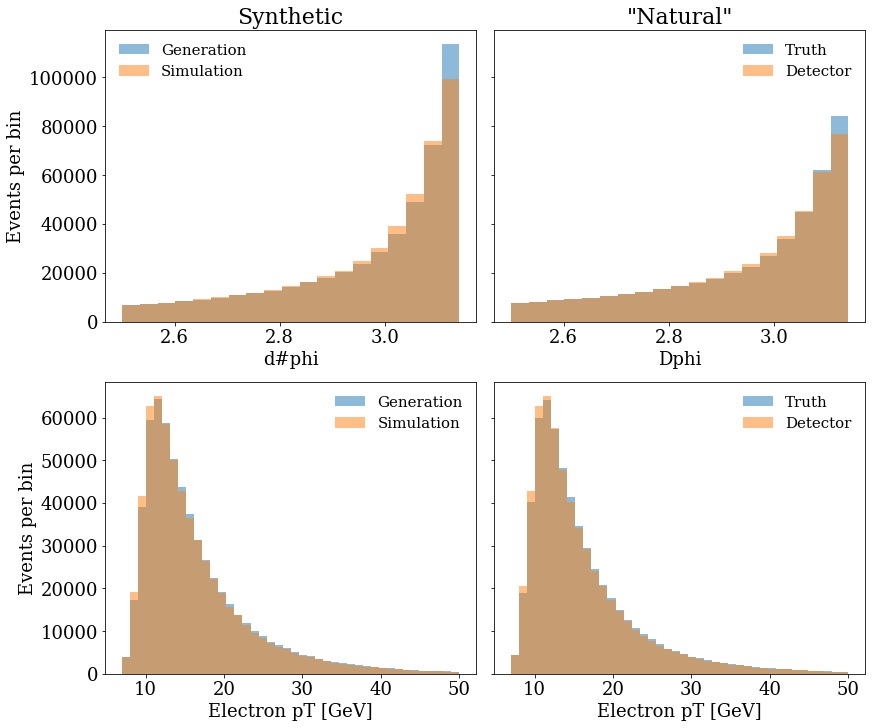

In [9]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(2.5, np.pi, 20)
## Define Multifold 
#bins = np.linspace(5, 50, 45)

ax[0, 0].set_title('Synthetic',fontsize=22)
ax[0, 0].set_xlabel(r'd#phi')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(dphi_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0, 0].hist(dphi_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0, 0].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"',fontsize=22)
ax[0, 1].set_xlabel('Dphi')
hG1, _, _ = ax[0, 1].hist(dphi_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[0, 1].hist(dphi_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[0, 1].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')






bins = np.linspace(7, 50, 43)

ax[1, 0].set_xlabel('Electron pT [GeV]')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(ept_0_G,
                          bins=bins,
                          alpha=0.5,
                          label='Generation')
hS0, _, _ = ax[1, 0].hist(ept_0_S,
                          bins=bins,
                          alpha=0.5,
                          label='Simulation')
legend = ax[1, 0].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Electron pT [GeV]')
hG1, _, _ = ax[1, 1].hist(ept_unknown_G,
                          bins=bins,
                          alpha=0.5,
                          label='Truth')
hS1, _, _ = ax[1, 1].hist(ept_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[1, 1].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center',fontsize=32)

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

## Define Multifold 

In [202]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):

    theta0_G = np.stack(theta0_G, axis=1)
    theta0_S = np.stack(theta0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)

    labels0 = np.zeros(len(theta0_G))
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=0,
                                  restore_best_weights=True)

    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights)) # np.squeeze(weights)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        #print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=0)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull
        
        #print('Max and min weight_pull in Step #1')
        #print(max(weights[i, 1, :]))
        #print(min(weights[i, 1, :]))
        

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        #print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=0)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull
        
        #print('Max and min weight_pull in Step #2')
        #print(max(weights[i, 1:2, :]))
        #print(min(weights[i, 1:2, :]))

    return weights, model

## Unfold two variables simultaneously

In [11]:
K.clear_session()

In [12]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=2,
                       theta0_G=(dphi_0_G / 100., ept_0_G / 100.),
                       theta0_S=(dphi_0_S / 100., ept_0_S / 100.),
                       theta_unknown_S=(dphi_unknown_S / 100.,
                                        ept_unknown_S / 100.))


ITERATION: 1

STEP 1

Epoch 1/200
89/89 [==============================] - 17s 186ms/step - loss: 0.6929 - accuracy: 0.5095 - val_loss: 0.6927 - val_accuracy: 0.5114
Epoch 2/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5146 - val_loss: 0.6924 - val_accuracy: 0.5182
Epoch 3/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5205 - val_loss: 0.6920 - val_accuracy: 0.5271
Epoch 4/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5254 - val_loss: 0.6916 - val_accuracy: 0.5316
Epoch 5/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5294 - val_loss: 0.6908 - val_accuracy: 0.5318
Epoch 6/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5311 - val_loss: 0.6907 - val_accuracy: 0.5329
Epoch 7/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5319 - val_loss: 0.6905 - val_accu

Epoch 8/200
91/91 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5003 - val_loss: 0.6759 - val_accuracy: 0.4987
Epoch 9/200
91/91 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5002 - val_loss: 0.6760 - val_accuracy: 0.4987
Epoch 10/200
91/91 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5004 - val_loss: 0.6753 - val_accuracy: 0.4983
Epoch 11/200
91/91 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5007 - val_loss: 0.6756 - val_accuracy: 0.4989
Epoch 12/200
91/91 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5005 - val_loss: 0.6753 - val_accuracy: 0.4986
Epoch 13/200
91/91 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5005 - val_loss: 0.6753 - val_accuracy: 0.4989
Epoch 00013: early stopping
Max and min weight_pull in Step #2
[0.92817873 1.1917218  1.18566084 ... 0.97424072 0.99590576 0.81691951]
[0.92817873 1.1

2020-11-19 10:36:48.575905: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-19 10:36:48.599402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-19 10:36:48.599916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2020-11-19 10:36:48.600058: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/miguel/anaconda3/envs/my_root_env/lib:
2020-11-19 10:36:48.600112: W tensorflow/stream_executor/platfor

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


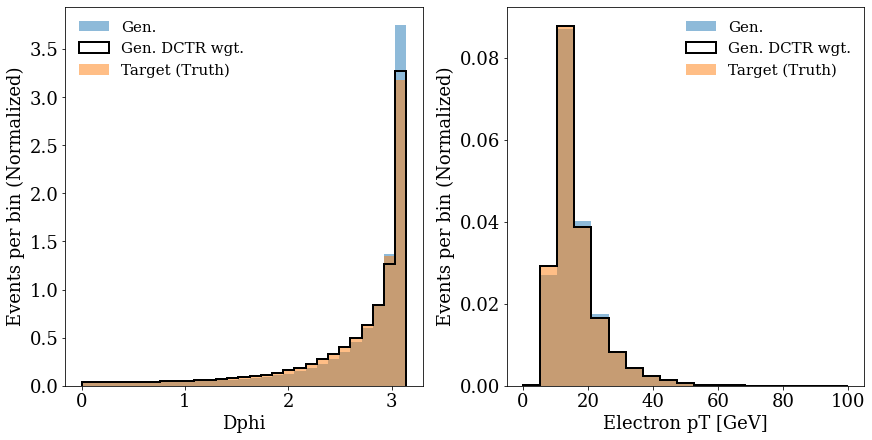

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


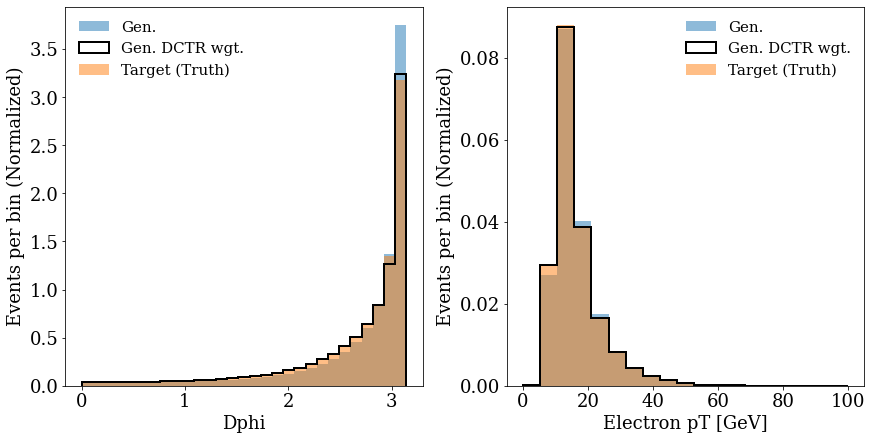

In [13]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 30)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('Dphi')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(dphi_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 100, 20)

    ax[1].set_xlabel('Electron pT [GeV]')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(ept_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

## 6D

In [14]:
K.clear_session()

In [15]:
num_observables = 6

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=2,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0,jeteta_0_G,qt_0_G,erap_0_G),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0,jeteta_0_S, qt_0_S,erap_0_S),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0,
                                        jeteta_unknown_S,
                                        qt_unknown_S,
                                        erap_unknown_S
                                        )
                      )


ITERATION: 1

STEP 1

Epoch 1/200
89/89 [==============================] - 17s 189ms/step - loss: 0.6894 - accuracy: 0.5384 - val_loss: 0.6886 - val_accuracy: 0.5422
Epoch 2/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5426 - val_loss: 0.6884 - val_accuracy: 0.5421
Epoch 3/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5436 - val_loss: 0.6882 - val_accuracy: 0.5424
Epoch 4/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5439 - val_loss: 0.6882 - val_accuracy: 0.5435
Epoch 5/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5441 - val_loss: 0.6882 - val_accuracy: 0.5435
Epoch 6/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5437 - val_loss: 0.6889 - val_accuracy: 0.5430
Epoch 7/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5444 - val_loss: 0.6881 - val_accu

89/89 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5474 - val_loss: 0.6875 - val_accuracy: 0.5465
Epoch 59/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5474 - val_loss: 0.6874 - val_accuracy: 0.5465
Epoch 60/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5473 - val_loss: 0.6875 - val_accuracy: 0.5461
Epoch 61/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5475 - val_loss: 0.6875 - val_accuracy: 0.5465
Epoch 62/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5475 - val_loss: 0.6875 - val_accuracy: 0.5462
Epoch 63/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5477 - val_loss: 0.6874 - val_accuracy: 0.5468
Epoch 64/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5478 - val_loss: 0.6874 - val_accuracy: 0.5458
Epoch 65/200
89/89 

89/89 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5259 - val_loss: 0.6821 - val_accuracy: 0.5240
Epoch 21/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5275 - val_loss: 0.6821 - val_accuracy: 0.5254
Epoch 22/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5272 - val_loss: 0.6821 - val_accuracy: 0.5217
Epoch 23/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5274 - val_loss: 0.6820 - val_accuracy: 0.5223
Epoch 24/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5256 - val_loss: 0.6821 - val_accuracy: 0.5320
Epoch 25/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5279 - val_loss: 0.6821 - val_accuracy: 0.5194
Epoch 26/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5275 - val_loss: 0.6821 - val_accuracy: 0.5187
Epoch 27/200
89/89 

In [16]:
for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))

3.050741672515869
0.3946865499019623
3.0053603649139404
0.3349182903766632


ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


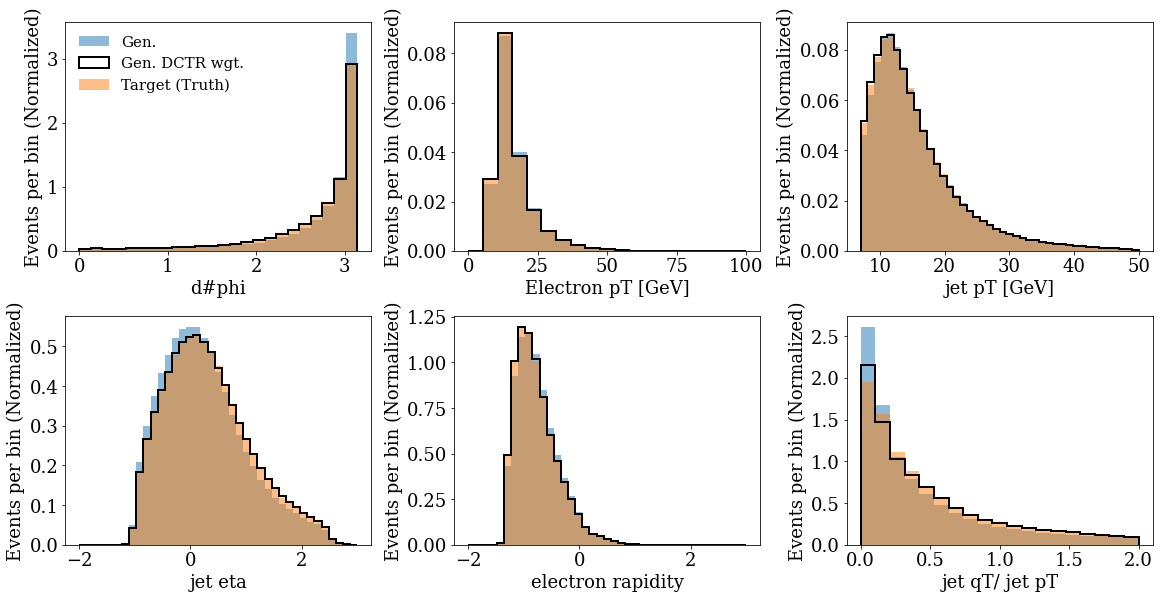

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


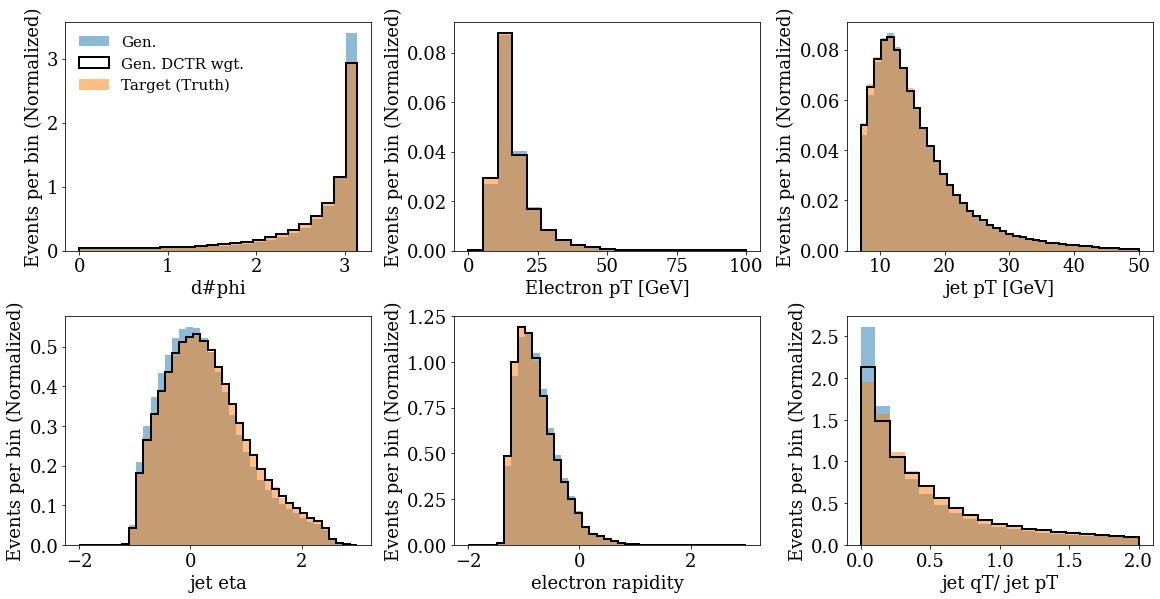

In [17]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 25)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(16, 8),
                           constrained_layout=True)
    ax[0,0].set_xlabel(r'd#phi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    bins = np.linspace(0, 100,20)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(7, 50, 43)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,2].hist(jetpt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,0].hist(jeteta_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,1].hist(erap_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 20)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,2].hist(qt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    


    
    
    
    fig.show()
    plt.show()

In [18]:
K.clear_session()

## Define features with data

In [19]:
dphi_0_G = mc_cut['genjet_dphi']
dphi_0_S =mc_cut['jet_dphi']
dphi_unknown_S = data_cut['jet_dphi']

ept_0_G = mc_cut['gene_pt']
ept_0_S =mc_cut['e_pt']
ept_unknown_S = data_cut['e_pt']

jetpt_0_G = mc_cut['genjet_pt']
jetpt_0_S =mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']

jeteta_0_G = mc_cut['genjet_eta']
jeteta_0_S =mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

qt_0_G = mc_cut['genjet_qtnormjetpt']
qt_0_S = mc_cut['jet_qtnormjetpt']
qt_unknown_S = data_cut['jet_qtnormjetpt']

erap_0_G = mc_cut['gene_rap']
erap_0_S = mc_cut['e_rap']
erap_unknown_S = data_cut['e_rap']


z_0_G = mc_cut['genjet_z']
z_0_S = mc_cut['jet_z']
z_unknown_S = data_cut['jet_z']

## Run unfolding on data

In [20]:
K.clear_session()

In [21]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=1,
                       theta0_G=(ept_0_G/10.0, jetpt_0_G/10.0),
                       theta0_S=(ept_0_S/10.0, jetpt_0_S/10.0),
                       theta_unknown_S=(ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0
                                        )
                      )


ITERATION: 1

STEP 1

Epoch 1/200
50/50 [==============================] - 9s 182ms/step - loss: 0.3464 - accuracy: 0.9128 - val_loss: 0.3112 - val_accuracy: 0.9132
Epoch 2/200
50/50 [==============================] - 0s 3ms/step - loss: 0.3097 - accuracy: 0.9128 - val_loss: 0.3047 - val_accuracy: 0.9132
Epoch 3/200
50/50 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.9128 - val_loss: 0.2959 - val_accuracy: 0.9132
Epoch 4/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2962 - accuracy: 0.9128 - val_loss: 0.2947 - val_accuracy: 0.9132
Epoch 5/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2958 - accuracy: 0.9128 - val_loss: 0.2946 - val_accuracy: 0.9132
Epoch 6/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2958 - accuracy: 0.9128 - val_loss: 0.2945 - val_accuracy: 0.9132
Epoch 7/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2957 - accuracy: 0.9128 - val_loss: 0.2946 - val_accur

50/50 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.9134 - val_loss: 0.2923 - val_accuracy: 0.9138
Epoch 59/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.9134 - val_loss: 0.2923 - val_accuracy: 0.9138
Epoch 60/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.9134 - val_loss: 0.2923 - val_accuracy: 0.9139
Epoch 61/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.9134 - val_loss: 0.2925 - val_accuracy: 0.9138
Epoch 62/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.9134 - val_loss: 0.2924 - val_accuracy: 0.9140
Epoch 63/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.9134 - val_loss: 0.2923 - val_accuracy: 0.9138
Epoch 64/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.9134 - val_loss: 0.2922 - val_accuracy: 0.9139
Epoch 65/200
50/50 

Epoch 116/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.9135 - val_loss: 0.2918 - val_accuracy: 0.9139
Epoch 117/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.9135 - val_loss: 0.2923 - val_accuracy: 0.9138
Epoch 118/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2931 - accuracy: 0.9135 - val_loss: 0.2918 - val_accuracy: 0.9139
Epoch 119/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.9135 - val_loss: 0.2919 - val_accuracy: 0.9140
Epoch 120/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.9135 - val_loss: 0.2920 - val_accuracy: 0.9140
Epoch 121/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2931 - accuracy: 0.9135 - val_loss: 0.2919 - val_accuracy: 0.9139
Epoch 122/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2932 - accuracy: 0.9135 - val_loss: 0.2919 - val_accuracy: 0.9139

In [22]:
num_observables = 6

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=3,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0,jeteta_0_G,qt_0_G,erap_0_G),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0,jeteta_0_S, qt_0_S,erap_0_S),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0,
                                        jeteta_unknown_S,
                                        qt_unknown_S,
                                        erap_unknown_S
                                        )
                      )


ITERATION: 1

STEP 1

Epoch 1/200
50/50 [==============================] - 15s 303ms/step - loss: 0.3740 - accuracy: 0.8917 - val_loss: 0.3001 - val_accuracy: 0.9132
Epoch 2/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2978 - accuracy: 0.9128 - val_loss: 0.2949 - val_accuracy: 0.9132
Epoch 3/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2949 - accuracy: 0.9128 - val_loss: 0.2929 - val_accuracy: 0.9132
Epoch 4/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2936 - accuracy: 0.9128 - val_loss: 0.2919 - val_accuracy: 0.9132
Epoch 5/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2929 - accuracy: 0.9128 - val_loss: 0.2913 - val_accuracy: 0.9132
Epoch 6/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2923 - accuracy: 0.9129 - val_loss: 0.2906 - val_accuracy: 0.9134
Epoch 7/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2917 - accuracy: 0.9130 - val_loss: 0.2903 - val_accu

50/50 [==============================] - 0s 6ms/step - loss: 0.2889 - accuracy: 0.9134 - val_loss: 0.2879 - val_accuracy: 0.9139
Epoch 59/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2890 - accuracy: 0.9135 - val_loss: 0.2881 - val_accuracy: 0.9139
Epoch 60/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2890 - accuracy: 0.9135 - val_loss: 0.2880 - val_accuracy: 0.9139
Epoch 61/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2890 - accuracy: 0.9135 - val_loss: 0.2881 - val_accuracy: 0.9140
Epoch 62/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2889 - accuracy: 0.9135 - val_loss: 0.2879 - val_accuracy: 0.9139
Epoch 63/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2889 - accuracy: 0.9135 - val_loss: 0.2883 - val_accuracy: 0.9140
Epoch 64/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2890 - accuracy: 0.9135 - val_loss: 0.2880 - val_accuracy: 0.9139
Epoch 65/200
50/50 

50/50 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.6107 - val_loss: 0.1206 - val_accuracy: 0.5623
Epoch 25/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.5938 - val_loss: 0.1207 - val_accuracy: 0.6509
Epoch 26/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.6102 - val_loss: 0.1206 - val_accuracy: 0.6185
Epoch 27/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.6005 - val_loss: 0.1206 - val_accuracy: 0.6555
Epoch 28/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.6013 - val_loss: 0.1207 - val_accuracy: 0.5334
Epoch 29/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.5912 - val_loss: 0.1207 - val_accuracy: 0.5832
Epoch 30/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.5871 - val_loss: 0.1206 - val_accuracy: 0.5892
Epoch 31/200
50/50 

Epoch 82/200
50/50 [==============================] - 0s 7ms/step - loss: 0.1202 - accuracy: 0.5519 - val_loss: 0.1205 - val_accuracy: 0.6307
Epoch 83/200
50/50 [==============================] - 0s 7ms/step - loss: 0.1202 - accuracy: 0.5563 - val_loss: 0.1204 - val_accuracy: 0.4765
Epoch 84/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1202 - accuracy: 0.5541 - val_loss: 0.1206 - val_accuracy: 0.6168
Epoch 85/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1202 - accuracy: 0.5522 - val_loss: 0.1204 - val_accuracy: 0.5128
Epoch 86/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1202 - accuracy: 0.5504 - val_loss: 0.1203 - val_accuracy: 0.5826
Epoch 87/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1202 - accuracy: 0.5596 - val_loss: 0.1204 - val_accuracy: 0.4230
Epoch 88/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1202 - accuracy: 0.5469 - val_loss: 0.1204 - val_accuracy: 0.5077
Epoch 

50/50 [==============================] - 0s 6ms/step - loss: 0.1205 - accuracy: 0.5728 - val_loss: 0.1208 - val_accuracy: 0.5367
Epoch 14/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1205 - accuracy: 0.5772 - val_loss: 0.1207 - val_accuracy: 0.6356
Epoch 15/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1205 - accuracy: 0.5836 - val_loss: 0.1207 - val_accuracy: 0.6696
Epoch 16/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1205 - accuracy: 0.5754 - val_loss: 0.1207 - val_accuracy: 0.5686
Epoch 17/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1205 - accuracy: 0.5823 - val_loss: 0.1206 - val_accuracy: 0.5001
Epoch 18/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1204 - accuracy: 0.5735 - val_loss: 0.1207 - val_accuracy: 0.6327
Epoch 19/200
50/50 [==============================] - 0s 7ms/step - loss: 0.1205 - accuracy: 0.5759 - val_loss: 0.1208 - val_accuracy: 0.6354
Epoch 20/200
50/50 

Max and min weight_pull in Step #2
[0.19752565 0.08751915 0.09008113 ... 0.08995012 0.10058457 0.17758645]
[0.19752565 0.08751915 0.09008113 ... 0.08995012 0.10058457 0.17758645]


In [23]:
for i in range(len(weights)):
    print (weights.shape)
    print((weights[i, 1, :]).shape)
    print((weights[i, 1, :]).shape)
    print((weights[i, 1:2, :][0]).shape)


(3, 2, 600050)
(600050,)
(600050,)
(600050,)
(3, 2, 600050)
(600050,)
(600050,)
(600050,)
(3, 2, 600050)
(600050,)
(600050,)
(600050,)


## Plot unfolded data

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


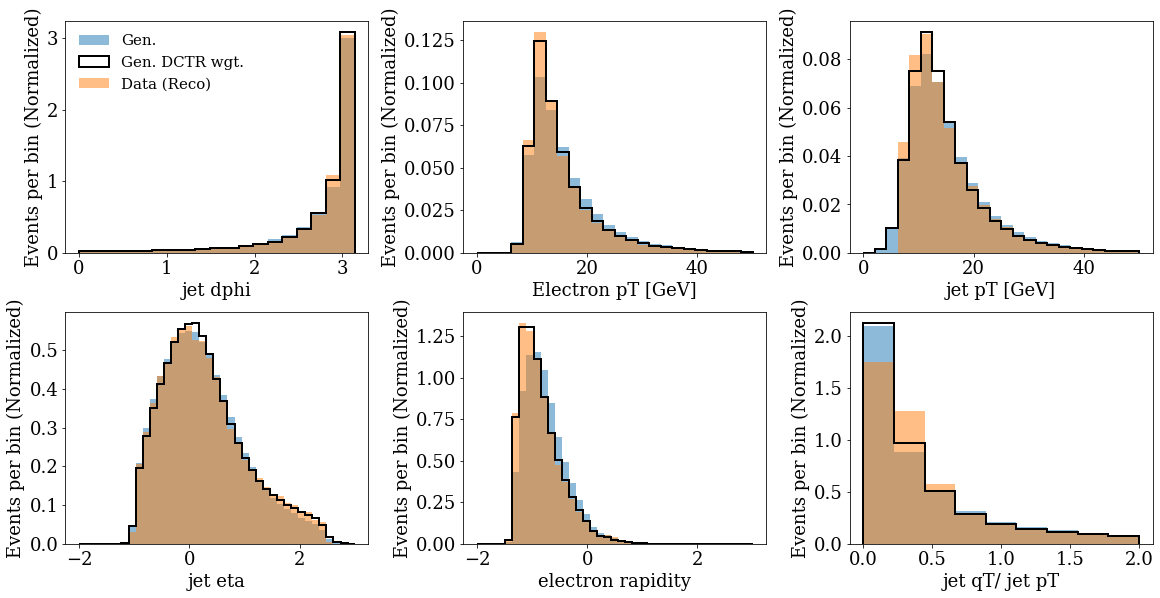

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


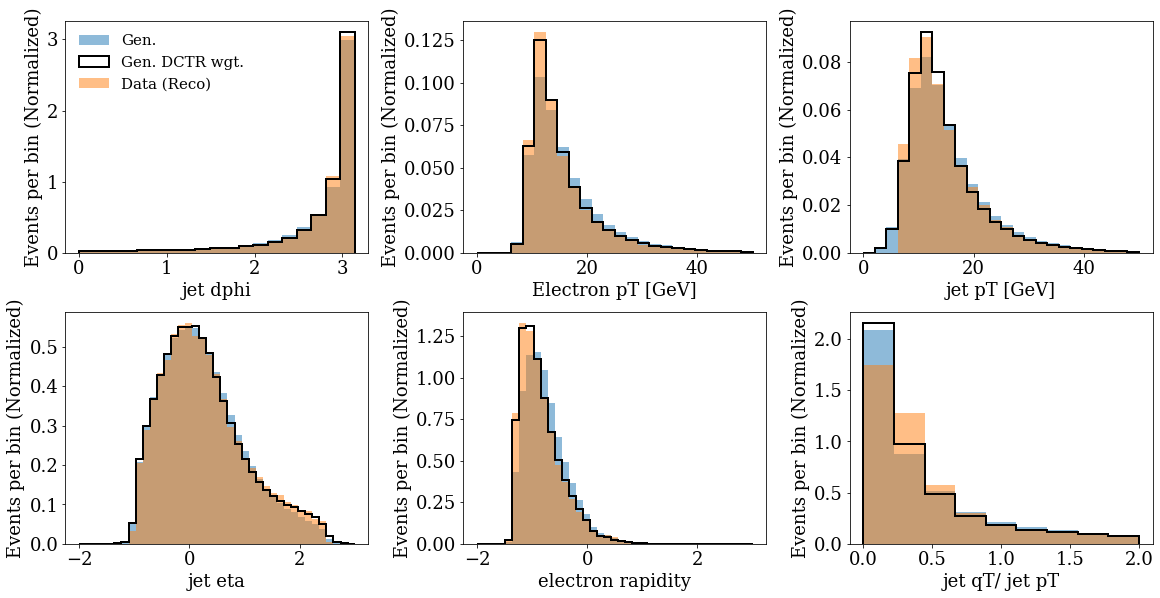

ITERATION: 3


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


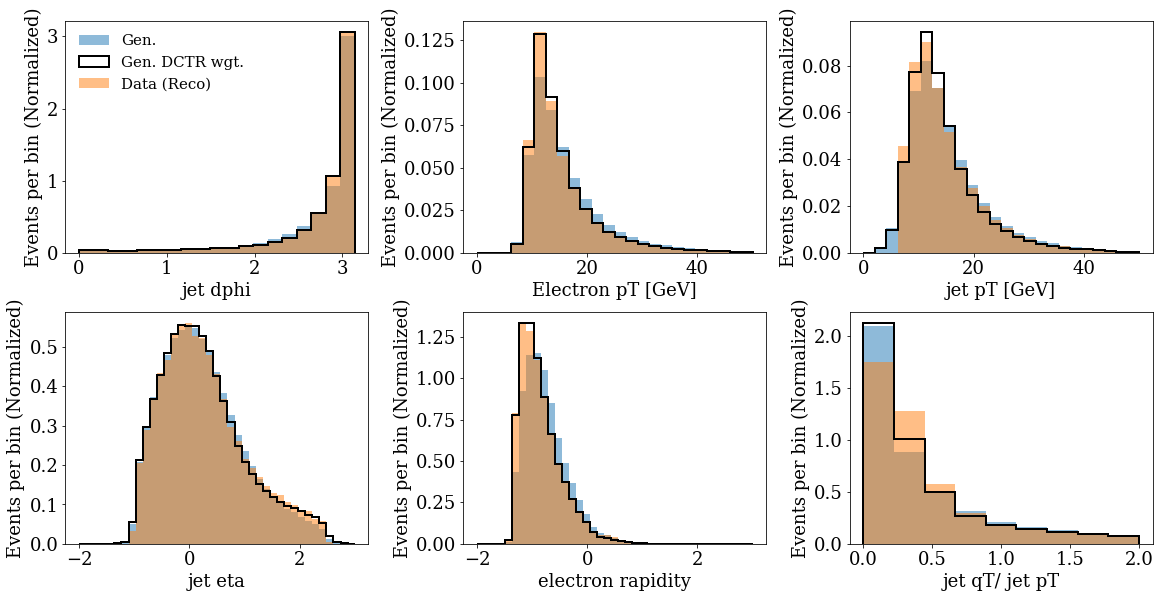

In [24]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 20)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(16, 8),
                           constrained_layout=True)
    ax[0,0].set_xlabel('jet dphi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_S,
               bins=bins,
               label=r'Data (Reco)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    bins = np.linspace(0, 50, 25)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt. = Unfolded',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(0, 50, 25)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,2].hist(jetpt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,0].hist(jeteta_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_S,
               bins=bins,
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,1].hist(erap_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_S,
               bins=bins,
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 10)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,2].hist(qt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_S,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    #bins = np.linspace(0, 1.5, 15)

    
    #ax[2,2].set_xlabel('jet z')
    #ax[2,2].set_ylabel('Events per bin (Normalized)')
    ##ax[2,2].hist(z_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    #ax[2,2].hist(z_0_G,
    #           bins=bins,
    #           weights=weights[i, 1, :],
    #           label=r'Gen. DCTR wgt.',
    #           **plot_style_1)
    #ax[2,2].hist(z_unknown_S,
    #           bins=bins,
    #           **plot_style_2)
    

    
    
    
    fig.show()
    plt.show()

## Plot the data at reco level and the gen weighted to match the data at reco level

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


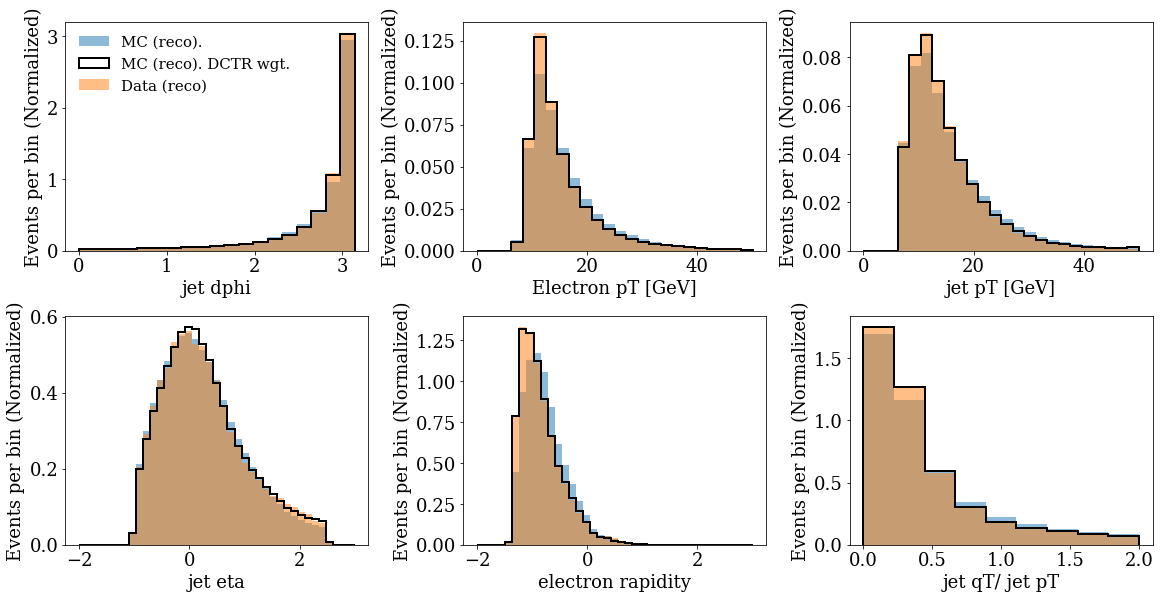

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


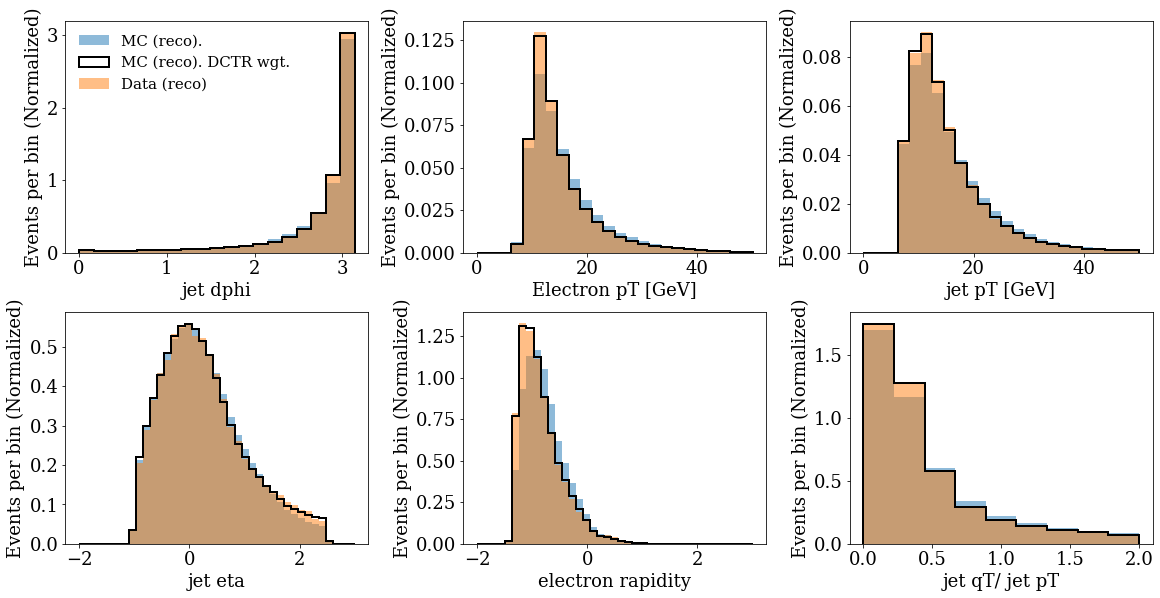

ITERATION: 3


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


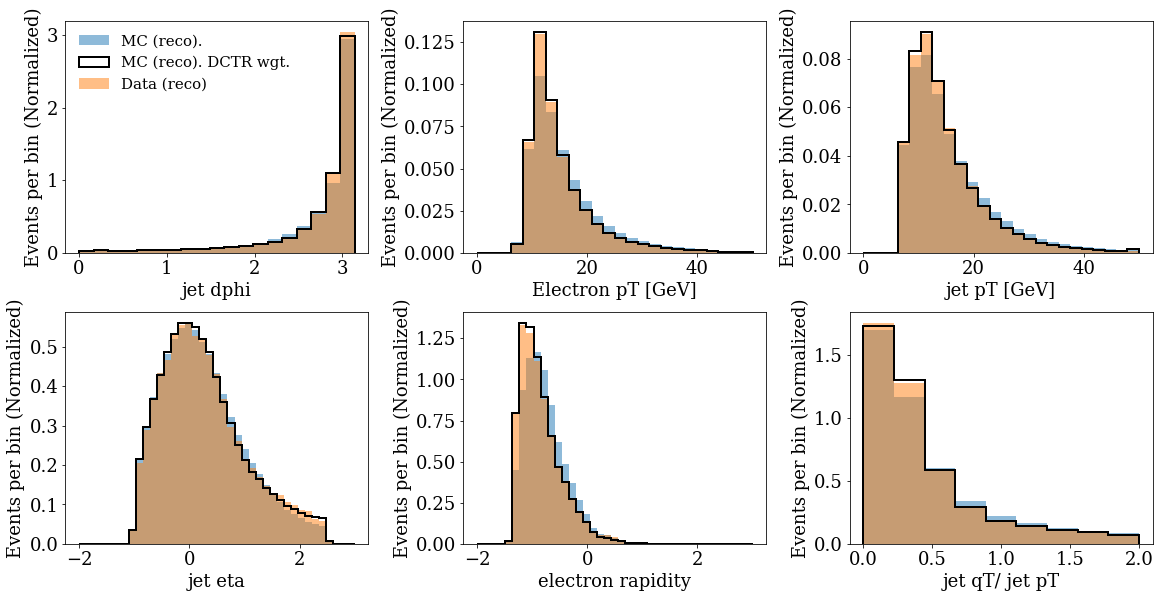

In [25]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 20)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(16, 8),
                           constrained_layout=True)
    ax[0,0].set_xlabel('jet dphi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_S, bins=bins, label=r'MC (reco).', **plot_style_2)
    ax[0,0].hist(dphi_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC (reco). DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    
    
    
    
    
    
    bins = np.linspace(0, 50, 25)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[0,1].hist(ept_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt. = Unfolded',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(0, 50, 25)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[0,2].hist(jetpt_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,0].hist(jeteta_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_S,
               bins=bins,
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,1].hist(erap_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_S,
               bins=bins,
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 10)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,2].hist(qt_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_S,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    bins = np.linspace(0, 1.5, 15)

    
    #ax[2,2].set_xlabel('jet z')
    #ax[2,2].set_ylabel('Events per bin (Normalized)')
    #ax[2,2].hist(z_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    #ax[2,2].hist(z_0_S,
    ##           bins=bins,
    #           weights=weights[i, 1:2, :][0],
    #           label=r'MC DCTR wgt.',
    #           **plot_style_1)
    #ax[2,2].hist(z_unknown_S,
    #           bins=bins,
    #           **plot_style_2)
    

    
    
    
    fig.show()
    plt.show()

## Create dataframe that includes weights

In [26]:
d = {'dphi': dphi_0_G, 'e_pt': ept_0_G, 'jet_pt': jetpt_0_G, 'weights': weights[i,1,:]}
df = pd.DataFrame(data=d)



## Plot data, and unfolded results and MC truth

## dphi 

###########
###########
###########


Text(0, 0.5, 'Normalized entries')

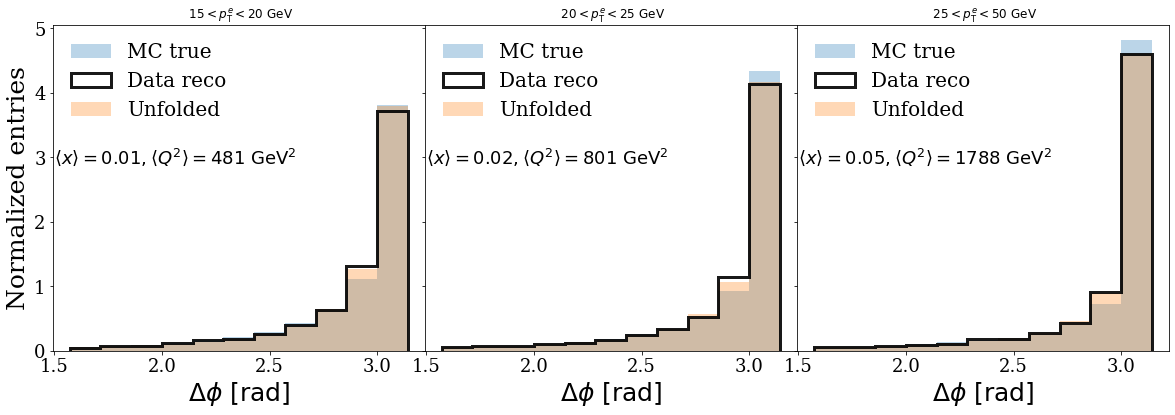

In [27]:
bins = np.linspace(np.pi/2.0, np.pi, 12)

#plt.hist(df.query('e_pt>15 and e_pt<20')['dphi'],
#               bins=bins,
#               weights=df.query('e_pt>15 and e_pt<20')['weights'],
#               label=r'Gen. DCTR wgt.',
#               **plot_style_1)



fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

nbins = 36#36
minimo = 2.8
for counter,edges in enumerate([(15,20), (20,25),(25,50)]):
    cut = 'e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1])
    df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text(r'$\Delta\phi$ $\mathrm{[rad]}$', fontsize=25)
    axs[counter].xaxis.set_label_text(r'$\Delta\phi$ $\mathrm{[rad]}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(df_cut['dphi'],bins=bins,density=True,label='MC true',alpha=0.3)
    axs[counter].hist(data_cut.query(cut)['jet_dphi'],bins=bins,alpha=0.9,density=True, label='Data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(df_cut['dphi'],bins=bins,weights=df_cut['weights'],density=True,label = 'Unfolded',alpha=0.3)

    axs[counter].legend(prop={'size': 20}, frameon=False, loc='upper left')
    axs[counter].set_title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$')

    axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #plt.yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


###########
###########
###########


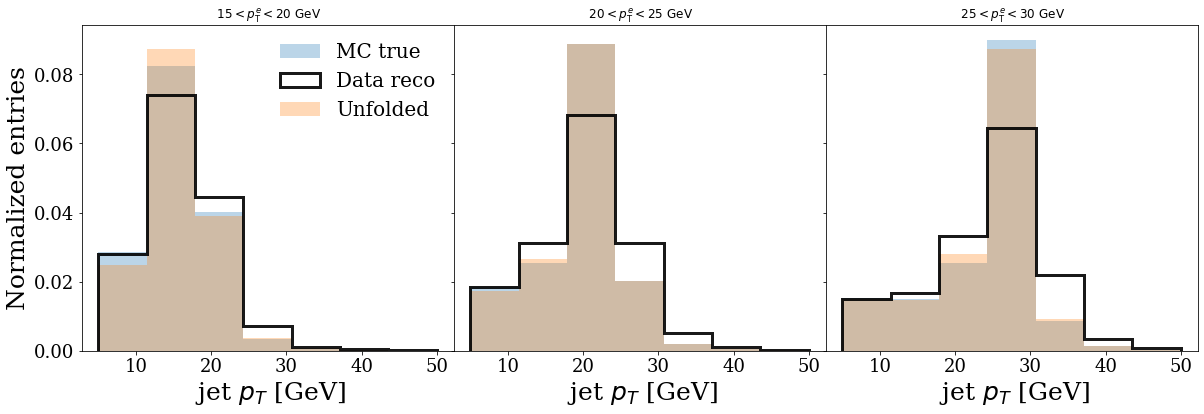

In [28]:
#bins = np.logspace(np.log10(7),np.log10(50),9)
bins = np.linspace(5,50,8)
#plt.hist(df.query('e_pt>15 and e_pt<20')['dphi'],
#               bins=bins,
#               weights=df.query('e_pt>15 and e_pt<20')['weights'],
#               label=r'Gen. DCTR wgt.',
#               **plot_style_1)



fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

nbins = 36#36
minimo = 2.8
for counter,edges in enumerate([(15,20), (20,25),(25,30)]):
    cut = 'e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1])
    df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text(r' jet $p_{T}$ [GeV]', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(df_cut['jet_pt'],bins=bins,density=True,label='MC true',alpha=0.3)
    axs[counter].hist(data_cut.query(cut)['jet_pt'],bins=bins,alpha=0.9,density=True, label='Data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(df_cut['jet_pt'],bins=bins,weights=df_cut['weights'],density=True,label = 'Unfolded',alpha=0.3)

    #axs[counter].legend(prop={'size': 20}, frameon=False, loc='upper left')
    axs[counter].set_title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$')

    #axs[counter].text(1.5,2.9, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #plt.yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)
axs[0].legend(prop={'size': 20}, frameon=False, loc='best')


###########
###########
###########


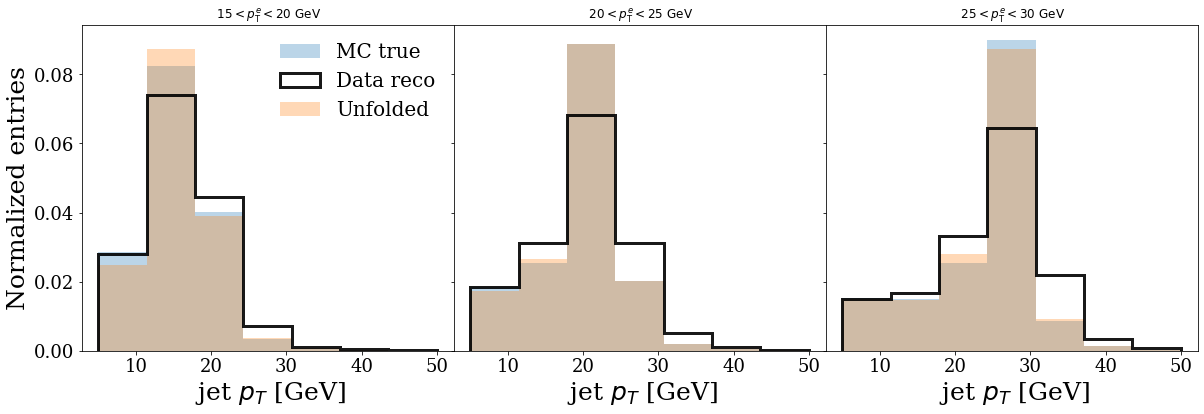

In [29]:
#bins = np.logspace(np.log10(7),np.log10(50),9)
bins = np.linspace(5,50,8)
#plt.hist(df.query('e_pt>15 and e_pt<20')['dphi'],
#               bins=bins,
#               weights=df.query('e_pt>15 and e_pt<20')['weights'],
#               label=r'Gen. DCTR wgt.',
#               **plot_style_1)



fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

nbins = 36#36
minimo = 2.8
for counter,edges in enumerate([(15,20), (20,25),(25,30)]):
    cut = 'e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1])
    df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text(r' jet $p_{T}$ [GeV]', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(df_cut['jet_pt'],bins=bins,density=True,label='MC true',alpha=0.3)
    axs[counter].hist(data_cut.query(cut)['jet_pt'],bins=bins,alpha=0.9,density=True, label='Data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(df_cut['jet_pt'],bins=bins,weights=df_cut['weights'],density=True,label = 'Unfolded',alpha=0.3)

    #axs[counter].legend(prop={'size': 20}, frameon=False, loc='upper left')
    axs[counter].set_title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$')

    #axs[counter].text(1.5,2.9, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #plt.yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)
axs[0].legend(prop={'size': 20}, frameon=False, loc='best')


In [74]:
## Final results 

## Bootstrapping, use MC first

In [30]:
## define MC first, these will be the same always

In [45]:
dphi_0_G = mc_cut['genjet_dphi']
dphi_0_S =mc_cut['jet_dphi']
ept_0_G = mc_cut['gene_pt']
ept_0_S =mc_cut['e_pt']
jetpt_0_G = mc_cut['genjet_pt']
jetpt_0_S =mc_cut['jet_pt']

In [108]:
def makeJackknifeDatasets(dataset, nDatasets):
    nEvents = dataset.shape[0]
    #print(nEvents)
    #print(nEvents/nDatasets)
    dropIndices = range(0, nEvents, int(nEvents/nDatasets))
    return [dataset.drop(dataset.index[slice(*indices)]) for indices in zip(dropIndices[:-1], dropIndices[1:])]    

jkDatasets = makeJackknifeDatasets(data_cut,100)


print(len(jkDatasets[2]))

56685


In [110]:
bootstraps = len(jkDatasets)
iterations = 1 
nvariables = 3

#for i, jkdata in enumerate(jkDatasets):
#    print ('ith jackknifedata')
    

In [112]:
bootstraps = len(jkDatasets)
iterations = 1 
nvariables = 3
weights = [] 


In [162]:
bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
print(bootstrap_data.shape[0])
bootstrap_data.head()


57257


,isBKG,polarization,x,y,Q2,x_e,y_e,Q2_e,vertex_z,ptratio,...,jet_p,jet_pt,jet_qt,jet_dphi,jet_z,jet_eta,jet_phi,__array_index,jet_qtnormjetpt,jet_qtnormept
32221,0.0,31.879999,0.042841,0.210546,916.144470,0.042547,0.212001,916.144470,14.799561,0.891442,...,34.214615,25.111469,1.907863,3.112977,0.940570,0.827654,3.760095,0,0.075976,0.071007
8737,0.0,32.950001,0.045547,0.234709,1085.799561,0.043520,0.245644,1085.799561,-2.273744,0.855388,...,29.204029,23.377737,5.489918,3.078500,0.873325,0.692112,3.355326,0,0.234835,0.191824
7349,0.0,0.000000,0.007445,0.323015,244.254837,0.006896,0.348752,244.254837,13.137817,0.867029,...,11.846495,10.795907,3.860914,2.848575,0.908896,-0.437664,2.154076,0,0.357628,0.306123
17958,0.0,25.160000,0.028579,0.236850,687.516479,0.026169,0.258663,687.516479,-2.019806,1.009201,...,34.767078,24.761370,2.241354,3.120513,0.851063,0.871172,2.521915,0,0.090518,0.099280
94203,0.0,0.000000,0.005153,0.388876,203.534332,0.004750,0.421898,203.534332,-5.709076,0.906872,...,12.912653,11.197804,1.253262,3.032362,0.872021,-0.546598,3.490080,0,0.111920,0.115537


In [163]:
data_cut.head()

,isBKG,polarization,x,y,Q2,x_e,y_e,Q2_e,vertex_z,ptratio,...,jet_p,jet_pt,jet_qt,jet_dphi,jet_z,jet_eta,jet_phi,__array_index,jet_qtnormjetpt,jet_qtnormept
8,0.0,13.510000,0.006797,0.260711,179.986847,0.007687,0.230541,179.986847,5.684937,0.979299,...,12.719501,12.557962,1.048791,3.084810,1.230839,-0.160225,5.010220,0,0.083516,0.089120
13,0.0,16.080000,0.013004,0.258633,341.601227,0.012774,0.263293,341.601227,-9.306458,0.895417,...,18.612930,17.042835,1.586532,3.077019,0.899058,0.426018,0.689243,0,0.093091,0.100010
14,0.0,16.080000,0.023728,0.429481,1035.069092,0.023945,0.425602,1035.069092,-6.796051,1.074758,...,26.846380,26.701992,2.321808,3.136937,1.037073,0.103948,5.237698,0,0.086953,0.095222
19,0.0,16.959999,0.013761,0.315783,441.353394,0.013752,0.315979,441.353394,4.207611,1.208110,...,22.856476,21.980793,5.026038,3.038584,1.005146,0.281342,2.814812,0,0.228656,0.289266
21,0.0,16.080000,0.006225,0.370844,234.466782,0.006073,0.380108,234.466782,9.495667,1.022693,...,14.444200,14.427497,6.528921,2.676172,0.732382,-0.048114,4.837780,0,0.452533,0.541555


In [251]:
K.clear_session()

In [ ]:
bootstraps = 100
iterations = 8 
nvariables = 3
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    dphi_unknown_S = bootstrap_data['jet_dphi']
    ept_unknown_S = bootstrap_data['e_pt']
    jetpt_unknown_S = bootstrap_data['jet_pt']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0
                                        )
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


0 th jackknifedata

ITERATION: 1

STEP 1


STEP 2



In [168]:
#for k in range(bootstraps):
#    for i in range(len(weights[k])):
        #print (weights[k].shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1:2, :][0]).shape)
print(myns[:,1])

[223.01459884 209.67593554 214.96265723 223.54304184 210.56414247
 223.91406919 229.97914225 211.86893207 220.05243869 229.53656365
 218.78382223 212.88521946 221.76302601 231.49366816 208.93361735
 232.2338387  216.99612485 214.54978724 225.22527054 226.36443475
 213.8697488  207.88628797 234.45264863 219.29815681 237.28698366
 230.07594084 218.87728858 221.88291024 194.36610872 220.55953569
 221.14650787 222.72619078 209.57557462 217.16749919 236.62281788
 227.89069122 221.81592538 213.08066274 225.53445935 219.24572834
 207.39540201 211.19606128 207.6020657  252.10362913 226.25413418
 240.24620983 226.62072742 217.94976852 203.70684081 224.74829231
 222.57494966 209.70466243 207.08238983 201.86530359 217.94171995
 214.68540953 199.63685978 213.14603822 199.70482785 195.73141341
 238.54613968 237.49351622 218.88972132 227.88413907 214.8172168
 217.62205921 208.52339766 219.67832684 205.46008066 221.07454199
 234.27546576 235.98220009 225.28409857 223.65557565 227.13947117
 219.389908

[[ 1.          0.45364066  0.20062866  0.18450737  0.17451247]
 [ 0.45364066  1.          0.58753492  0.19724863 -0.16696291]
 [ 0.20062866  0.58753492  1.          0.63780119  0.1084039 ]
 [ 0.18450737  0.19724863  0.63780119  1.          0.48434717]
 [ 0.17451247 -0.16696291  0.1084039   0.48434717  1.        ]]


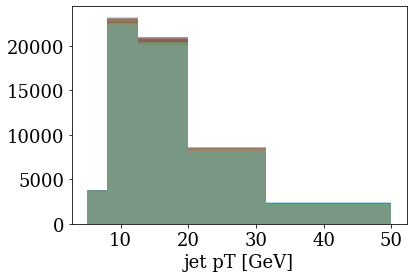

In [228]:
covariance_matrices = []
for it in range(3):
    myns = []
    bins = np.logspace(np.log10(5),np.log10(50),6)
#bins = np.linspace(0.0,np.pi,12)

    for k in range(bootstraps):
        n,b,_ = plt.hist(jetpt_0_S,bins=bins,weights=weights[k][it, 1, :],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    plt.xlabel('jet pT [GeV]')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [232]:
print(covariance_matrices[0])
print(covariance_matrices[1])
print(covariance_matrices[2])


[[ 1.          0.45364066  0.20062866  0.18450737  0.17451247]
 [ 0.45364066  1.          0.58753492  0.19724863 -0.16696291]
 [ 0.20062866  0.58753492  1.          0.63780119  0.1084039 ]
 [ 0.18450737  0.19724863  0.63780119  1.          0.48434717]
 [ 0.17451247 -0.16696291  0.1084039   0.48434717  1.        ]]
[[1.         0.65147544 0.43606461 0.47786855 0.25438154]
 [0.65147544 1.         0.65244793 0.309561   0.06314483]
 [0.43606461 0.65244793 1.         0.41838964 0.16341603]
 [0.47786855 0.309561   0.41838964 1.         0.50804864]
 [0.25438154 0.06314483 0.16341603 0.50804864 1.        ]]
[[ 1.          0.47310603  0.14753499  0.08802087  0.07599597]
 [ 0.47310603  1.          0.52589402  0.25046776 -0.00775981]
 [ 0.14753499  0.52589402  1.          0.55396207  0.23458555]
 [ 0.08802087  0.25046776  0.55396207  1.          0.62636262]
 [ 0.07599597 -0.00775981  0.23458555  0.62636262  1.        ]]


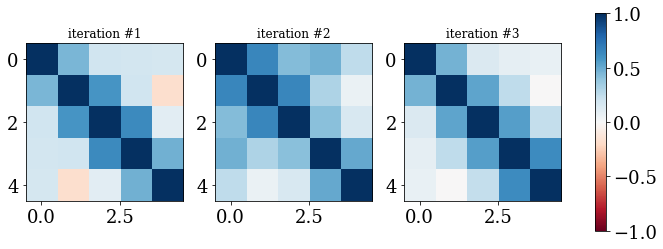

In [234]:
fig, ax = plt.subplots(1,3,figsize=(12,4)) 
im = ax[0].imshow(covariance_matrices[0],cmap='RdBu', vmin=-1.0, vmax=1.0,
                             interpolation='none')
im = ax[1].imshow(covariance_matrices[1],cmap='RdBu', vmin=-1.0, vmax=1.0,
                             interpolation='none')
im = ax[2].imshow(covariance_matrices[2],cmap='RdBu', vmin=-1.0, vmax=1.0,
                  interpolation='none')

ax[0].set_title('iteration #1')
ax[1].set_title('iteration #2')
ax[2].set_title('iteration #3')

fig.colorbar(im,ax=ax)
plt.show()

In [235]:
np.matrix(covariance_matrices[0])

matrix([[ 1.        ,  0.45364066,  0.20062866,  0.18450737,  0.17451247],
        [ 0.45364066,  1.        ,  0.58753492,  0.19724863, -0.16696291],
        [ 0.20062866,  0.58753492,  1.        ,  0.63780119,  0.1084039 ],
        [ 0.18450737,  0.19724863,  0.63780119,  1.        ,  0.48434717],
        [ 0.17451247, -0.16696291,  0.1084039 ,  0.48434717,  1.        ]])

In [247]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(3): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it)
    print (rho_it)
print (x)
print (rhos)

0.6946804418565995
0.6774503437970508
0.65830113861157
[0, 1, 2]
[0.6946804418565995, 0.6774503437970508, 0.65830113861157]


(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

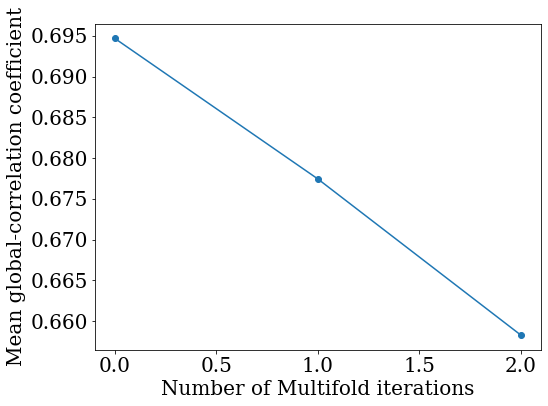

In [250]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [206]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [207]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

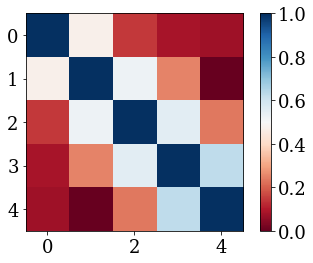

In [211]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()

In [210]:
print(corr)

[[ 1.          0.47310603  0.14753499  0.08802087  0.07599597]
 [ 0.47310603  1.          0.52589402  0.25046776 -0.00775981]
 [ 0.14753499  0.52589402  1.          0.55396207  0.23458555]
 [ 0.08802087  0.25046776  0.55396207  1.          0.62636262]
 [ 0.07599597 -0.00775981  0.23458555  0.62636262  1.        ]]


In [156]:

l = dphi_unknown_S
for i in range(10):
    ll = np.random.choice(l, size=l.shape, replace=False) 
    print(ll)
    print(len(ll))

[0.3986636 3.0958765 1.6596488 ... 3.1276221 3.0854604 1.30305  ]
56685
[2.9751363 2.6826715 3.00907   ... 2.8723137 2.2210207 2.456263 ]
56685
[3.128272  2.8021085 3.0836308 ... 2.4065924 3.0136344 3.1349   ]
56685
[2.8575413 2.4011052 3.1368954 ... 3.0095334 0.0419554 2.786938 ]
56685
[2.7881622 3.1293275 0.9728438 ... 3.0804713 2.8625584 3.133007 ]
56685
[3.0746589 2.8675857 3.0929246 ... 1.9085506 2.9734626 2.7695072]
56685
[2.9366975 3.056436  3.0891428 ... 3.0419383 3.0592315 3.081324 ]
56685
[2.9311266 3.065919  3.127693  ... 3.0626194 2.7039013 3.0575848]
56685
[3.1334968 3.122569  3.1335804 ... 3.1398609 2.9542744 2.6663394]
56685
[3.048649  3.0348523 3.077688  ... 2.5505466 2.6407883 2.4437428]
56685


In [154]:
np.mean(ll)

2.7473767